## Generative Virtual Screening NIM Blueprint
This example notebook demonstrates how to connect BioNeMo NIMs to carry out a few key steps of a virtual screening workflow. Importantly, these steps are powered by highly performant AI models in each category: AlphaFold2 for folding, MolMIM for molecular generation, and DiffDock for protein-ligand docking.

![image](generative-virtual-screening-blueprint.png)

Below, we illustrate this workflow using an example protein and example molecule of interest, the SARS-CoV-2 main protease and Nirmatrelvir, however, the user is free to define any protein and molecule of their choosing.

All of these capabilities are enabled by NVIDIA NIM and NVIDIA NIM Blueprints. For more details, please visit [NVIDIA NIM Blueprints](https://build.nvidia.com/nim/blueprints) and the [GitHub resources](https://github.com/NVIDIA-NIM-Agent-Blueprints/generative-virtual-screening).

### BioNeMo Configurations
Before you begin, please set the NGC_CLI_API_KEY environment variable to a personal run key for your NGC Org and Team before running docker compose. Then, you can spin the NIMs up using the following docker command from the same directory as the `docker-compose.yaml`:

`docker compose up`

In [1]:
# Defining NABs inference endpoints once the AlphaFold-2, MolMIM, and DiffDock NIMs are running
import requests

AF2_HOST = 'http://localhost:8081'
DIFFDOCK_HOST = 'http://localhost:8082'
MOLMIM_HOST = 'http://localhost:8083'

### Visualization setup


Please make sure the required packages and dependencies are installed. You may install the required packages using the following `pip install` command.

In [2]:
# Please run the following 'pip install' command to install the required libraries
!pip install jupyter ipywidgets loguru py3dmol rdkit pandas

# Importing libraries for 3-D visualization
import py3Dmol
import ipywidgets as widgets
from IPython.display import display

# Importing libraries from RD-Kit for handling and manipulating chemical data
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, QED
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

### Protein Folding with AlphaFold2
Once a protein target of interest has been identified, the first step of this virtual screening demonstration is to generate a plausible structure of that protein. We do so by using AlphaFold2, a generative, transformer-based model that translates protein sequences into protein structures.

To demonstrate this part of our workflow, we begin with an example protein. Here, we choose the SARS-CoV-2 main protease as our starting sequence. We query the AlphaFold2 endpoint with this sequence and the model returns the predicted protein structure.

Please note that this step may take 15~20 minutes to be finished (depending on the GPU type), which is much slower than the other two inference steps that usually requires less than a minute

In [3]:
# SARS CoV-2 main protease sequence
protein = "SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ"

In [4]:
# Query AlphaFold2 with sequence above
af2_response = requests.post(
    f'{AF2_HOST}/protein-structure/alphafold2/predict-structure-from-sequence',
    json={
        'sequence': protein,
        'databases': ['uniref90', 'mgnify', 'small_bfd'],
        'msa_algorithm': 'jackhmmer',
        'e_value': 0.0001,
        'bit_score': -1, # -1 means to fallback to the e-value
        'msa_iterations': 1,
        'relax_prediction': True,
    }).json()

In [5]:
# Receive protein structure for SARS CoV-2 protease
folded_protein = af2_response[0]

In [6]:
# [OPTIONAL STEP]: Write the structure coordinates to a file
filename = "folded_protein.pdb"

# Open the file in write mode
with open(filename, 'w') as file:
    # Write some text to the file
    file.write(folded_protein)

In [7]:
# Printing a subset of atomic 3-D coordinates from the AlphaFold-2 predicted structure
print(folded_protein[:483])

ATOM      1  N   SER A   1     -16.098 -16.105  13.160  1.00 69.92           N  
ATOM      2  H   SER A   1     -16.947 -16.583  12.895  1.00 69.92           H  
ATOM      3  H2  SER A   1     -15.423 -16.740  13.561  1.00 69.92           H  
ATOM      4  H3  SER A   1     -16.323 -15.406  13.852  1.00 69.92           H  
ATOM      5  CA  SER A   1     -15.503 -15.402  12.003  1.00 69.92           C  
ATOM      6  HA  SER A   1     -15.405 -16.090  11.163  1.00 69.92           H


#### Structural Visualization

The predicted structure can be visualized using tools such as PyMol, VMD, Chimera, etc. 

Here, we will use Py3DMol inside this Jupyter Notebook for 3-D visualization.

The structure prediction by AlphaFold-2 also provides atomic pLDDT scores, reflecting the prediction confidence score. These values are written in the B-factor column in a PDB file. 

Here, the 3-D visualization is rendered to approximate pLDDT scores per the following color range.

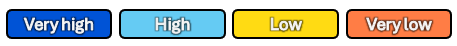


In [8]:
# Visualizing AlphaFold2 predicted protein structure using Py3DMol viewer
# Initialize the viewer
view = py3Dmol.view(width=1200, height=900)

# Add the protein structure from the PDB data
view.addModel(folded_protein, "pdb")

# Set the style and color by B-factor (approximating colors for pLDDT scores)
view.zoomTo()
view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 40, 'max': 100}}})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Molecular Generation with MolMIM
The next step in our workflow is generating molecules with optimized chemical properties starting from a seed molecule of interest. Here, molecular generation is powered by MolMIM, an LLM-inspired model aimed at generating and optimizing molecules according to user-defined objectives. The "MIM" part of MolMIM stands for Mutual Information Machine, which describes the mutual-information-based loss used to preserve chemical similarity in the model's latent space.

Here, we begin with Nirmatrelvir, an active component of the Covid treatment Paxlovid, aimed at targeting the SARS-CoV-2 main protease. By using this molecule as the input to MolMIM, the model will return 5 generated molecules with the highest chemical similarity to MolMIM. The user is able to specify the number of generated molecules to return when querying the MolMIM NIM.

Additionally, the user is able to specify chemical properties to optimize for. In this example, we have chosen to optimize the Quantitative Estimate of Drug-Likeness (QED) score, to produce molecules with favorable pharmacokinetic properties.

Note especially that here we're using the `/generate` endpoint of the MolMIM NIM.  But MolMIM was designed for controlled generation with user-defined oracles.  For this type of application you will want to call the `/decode` endpoint.  See the [documentation](https://docs.nvidia.com/nim/bionemo/molmim/latest/overview.html#decode) and [example notebook](https://github.com/NVIDIA/BioNeMo/blob/main/examples/service/notebooks/cma_custom_oracles.ipynb) for additional information about using user-defined oracles.

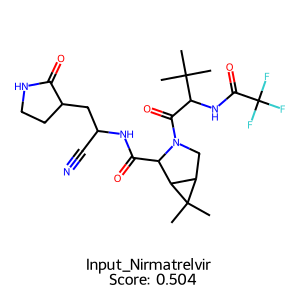

In [9]:
# Nirmatrelvir SMILES formula
molecule = "CC1(C2C1C(N(C2)C(=O)C(C(C)(C)C)NC(=O)C(F)(F)F)C(=O)NC(CC3CCNC3=O)C#N)C"

# Visualizing 2-D structures and QED Score for input compound
input_mol = Chem.MolFromSmiles(molecule)
input_qed = QED.qed(input_mol)
Draw.MolToImage(input_mol, legend=str("Input_Nirmatrelvir \n Score: "+ "%.3f" % input_qed), subImgSize=(350,350))

In [10]:
# Inferencsing using MolMIM for compound generation
molmim_response = requests.post(
    f'{MOLMIM_HOST}/generate',
    json={
        'smi': molecule,
        'num_molecules': 5,
        'algorithm': 'CMA-ES',
        'property_name': 'QED',
        'min_similarity': 0.6, # Ignored if algorithm is not "CMA-ES".
        'iterations': 10,
    }).json()

generated_ligands = '\n'.join([v['smiles'] for v in molmim_response['generated']])

Total unique molecule designs obtained: 5


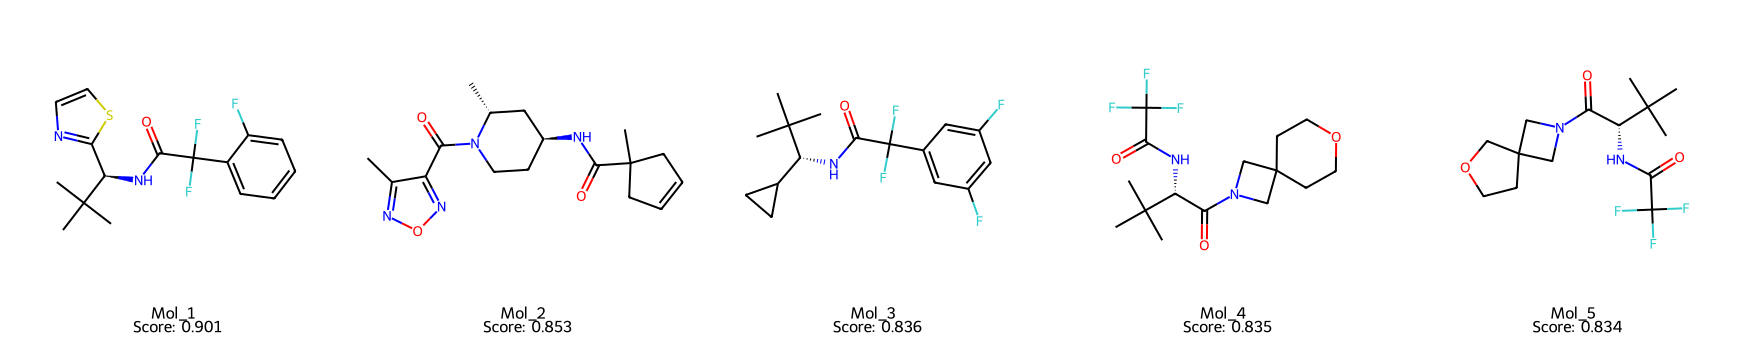

In [11]:
# Visualizing 2-D structures of MolMIM-generated compounds
mols_from_gen_smis = []
gen_legends = []
for index, i in enumerate(molmim_response['generated']):
    # Convert SMILES to molecule and ensure uniqueness
    mol = Chem.MolFromSmiles(i['smiles'])
    if mol and mol not in mols_from_gen_smis:
        mols_from_gen_smis.append(mol)
        gen_legends.append(f"Mol_{index + 1} \n Score: {i['score']:.3f}")

# Output the number of unique molecules
print("Total unique molecule designs obtained:", len(mols_from_gen_smis))

# Draw the molecules in a grid
Draw.MolsToGridImage(mols_from_gen_smis, legends=gen_legends, molsPerRow=5, subImgSize=(350, 350))

### Protein-Ligand Docking with DiffDock

After obtaining the molecules with optimized QED scores, we can predict their binding poses to the receptor target. Here, we apply DiffDock, a state-of-the-art generative model that predicts the 3D structure of a protein-ligand complex, to find out the best (most probable) binding poses. A highlighted feature from DiffDock is that a presumed binding pocket, which usually can be characterized only from experimental 3D structures, is not needed (a.k.a., blind-docking). This feature is very useful for AI folded protein structures, as it is able to locate all regions on the protein surface to be bound by drug molecules, providing ingishts for further downstream investigations.

The optimized DiffDock also provides the batch-docking function, by which we can concatenate multiple molecules into one request of docking, each of them will be also sampled for mulitple poses (i.e., `num_poses=10` in this example). In the output, the predicted docking poses for each molecule is sorted by a confidence score that inferenced from a confidence model.

In [12]:
diffdock_response = requests.post(
    f'{DIFFDOCK_HOST}/molecular-docking/diffdock/generate',
    json={
        'protein': folded_protein,
        'ligand': generated_ligands,
        'ligand_file_type': 'txt',
        'num_poses': 10,
        'time_divisions': 20,
        'num_steps': 18,
    }).json()

In [13]:
# Extracting the top1 poses docking coordinates and scores for each generated molecule
best_scores, best_scoring_poses = [], []

for i in range(len(diffdock_response['ligand_positions'])):
    best_scoring_poses.append(diffdock_response['ligand_positions'][i][0])
    best_scores.append(diffdock_response['position_confidence'][i][0])

In [14]:
# defining a function for color definitions for visualization
def ansi_color(text, color):
    """Color text for console output"""
    colors = {
        "red": "\033[31m",
        "green": "\033[32m",
        "yellow": "\033[33m",
        "blue": "\033[34m",
        "magenta": "\033[35m",
        "cyan": "\033[36m",
        "white": "\033[37m",
        "reset": "\033[0m"
    }
    return f"{colors[color]}{text}{colors['reset']}"

# Assuming `docking_poses` is a list of RDKit molecule objects, each representing a docking pose for a compound
# Example: docking_poses = [mol1, mol2, mol3, mol4, mol5]

# Function to update the viewer based on the selected compound index
def update_viewer(compound_index):
    view = py3Dmol.view(width=1200, height=900)


    # Add the protein model
    view.addModel(folded_protein, 'pdb')
    view.setStyle({'model': 0}, {'cartoon': {'color': 'white', 'opacity': 0.7}})
    view.setViewStyle({'style':'outline','color':'black','width':0.03})
    Prot=view.getModel()
    Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
    view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 40, 'max': 100}}})
    view.addSurface(py3Dmol.VDW,{'opacity':0.4,'color':'white'})
    
    # Add the selected docking pose
    pose = best_scoring_poses[compound_index]
    # pose_block = Chem.MolToMolBlock()
    view.addModel(pose, 'mol')
    view.addSurface(py3Dmol.VDW, {'opacity': 0.5, 'colorscheme': 'magentaCarbon'}, {'model': 1})
    view.setStyle({'model': 1}, {'stick': {'radius': 0.3, 'colorscheme': 'magentaCarbon'}})
    score = round(best_scores[compound_index], 3)
    score_color = "green" if score > -0.5 else "blue" if score >= -1.5 else "red"
    print(f"Loaded {ansi_color(compound_index+1, 'magenta')} with XX_confidence score: {ansi_color(best_scores[compound_index], score_color)}")

    # Zoom to fit the structure
    view.zoomTo()
    
    # Display the viewer
    return view.show()

# Create a slider widget to select compounds
compound_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(best_scoring_poses) - 1,
    step=1,
    description='Compound:',
    continuous_update=False,
    orientation='horizontal',
    readout=False,
    readout_format='d'
)

# Link the slider to the viewer update function
widgets.interact(update_viewer, compound_index=compound_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Compound:', max=4, readout=Fals…

<function __main__.update_viewer(compound_index)>

In this workflow, we illustrate the ability of BioNeMo NIMs to work in concert to generate meaningful predictions in a small virtual screening workflow. We hope this underscores to the user how easy the tools are to query and assimilate, and how flexible a workflow of this sort can be.